# <center>Practical 09: Part 2 - Deep RL</center>

<p style="color:#0000FF";> <b>Let's first make sure that all the required dependencies are installed (you can skip this step if dependencies are already installed)</b></p> 

### With pip (in your local machine)
1. Open Anaconda prompt
2. Type ``pip install gym``
3. If pip is missing, type ``conda install pip``
4. If using a GPU, type ``pip install torch==1.6.0+cu101 torchvision==0.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html``
5. If using a CPU, type ``pip install torch==1.6.0+cpu torchvision==0.7.0+cpu -f https://download.pytorch.org/whl/torch_stable.html``

### In AWS
1. Add and execute the following line at the beginning of your notebook
```python 
import sys
!{sys.executable} -m pip install gym```
2. Kernels with ``torchvision`` and ``pytorch`` are already installed and ready to be used
3. Go to ``Kernel -> Change kernel`` and select ``conda_pytorch_latest_p36``

# CartPole Environment

In this notebook, we will use DQN to solve the Cart-Pole environment.

<img src="Support/images/cartPole.gif" height="400" width="400" align="center">

## State Space
The state space of this environment is defined by a 4-tuple where each value represents:

<img src="Support/images/cartPole_actionSpace.png" height="400" width="400" align="center">

## Action Space
There are just two possible discrete actions

<table>
<thead>
<tr>
<th>Num</th>
<th>Action</th>
</tr>
</thead>
<tbody>
<tr>
<td>0</td>
<td>Push cart to the left</td>
</tr>
<tr>
<td>1</td>
<td>Push cart to the right</td>
    </tr>
</table>

## Rewards

Reward is 1 for every step taken, including the termination step

## Other Considerations
- When choosing the starting state, all observations are assigned a uniform random value in [-0.05..0.05]
- An episode is considered as terminated if:
    - Pole Angle is more than 12 degrees.
    - Cart Position is more than 2.4 (center of the cart reaches the edge of the display).
    - Episode length is greater than 200.
    
    
**The environment is considered to be solved when the average return is greater than or equal to 195.0 over 100 consecutive trials.**

In [1]:
# Import all required dependencies

import gym
import math
import random
import numpy as np
from collections import namedtuple
import copy
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 


import matplotlib.pyplot as plt
%matplotlib inline

import io
import base64
from IPython.display import HTML
from IPython.display import clear_output

import sys
import os
sys.path.insert(0, os.path.abspath('Support'))

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## DQN Algorithm

With a random policy, the cart pole control is very poor. We got only 13 points as return.

Let's use Deep Q-learning to improve the performance of the cart pole

In [2]:
video = io.open('Support/images/randomPolicy.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''
    <video width="360" height="auto" alt="test" controls><source src="data:video/mp4;base64,{0}" type="video/mp4" /></video>'''
.format(encoded.decode('ascii')))

Our implementation follows the algorithm proposed by *Mnih et .al* in  <a href="https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf">Playing Atari with Deep Reinforcement Learning</a> 

<img src="Support/images/dqn_replay.png" width="600" height="600" align="center">

We have decomposed the algorithm shown above into:
- A ReplayMemory class to represent and encode the Replay Buffer
- A DQN class to represent our NN function approximator
- An agent class which contains the learning logic of the algorithm
- A main loop in which transition tuples ('state', 'action', 'next_state', 'reward', 'done') are generated and added to the replay buffer. This loop also calls the agent ``optimize(.)`` method to train our approximator


### Replay Buffer

Let's first define our representation of the replay buffer. To do so, we will use the class ``ReplayMemory`` shown below

In [3]:
# This tuple represents one observation in our environment
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward', 'done'))

class ReplayMemory:
    """
    A cyclic buffer of bounded size (capacity) that holds the transitions 
    observed recently. 
    
    It also implements a sample() method for selecting a random 
    batch of transitions for training.
    """
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        """Returns a minibatch of `Transition` randomly
        Args:
            batch_size (int): Size of mini-bach
        Returns:
            List[Transition]: Minibatch of `Transition`
        """
        return random.sample(self.memory, batch_size)

    def __len__(self):
        """Returns the length """
        return len(self.memory)

### DQN Network

Let us now define the Multi Layer Perceptron network that will be used as the function approximator for the action-value function (q-function)

In [4]:
class DQN(nn.Module):
    """DQN Network
        Args:
        input_dim (int): `state` dimension.
        output_dim (int): Number of actions.
        hidden_dim (int): Hidden dimension in fully connected layer
    """
    def __init__(self, num_inputs=4, num_actions=2, hidden_dim=128):
        super(DQN, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(num_inputs, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_actions)
        )
        
    def forward(self, x):
        """Returns a Q_value
        Args:
            x (torch.Tensor): `State` 2-D tensor of shape (n, num_inputs)
        Returns:
            torch.Tensor: Q_value, 2-D tensor of shape (n, num_actions)
        """
        return self.layers(x)

### DQN Agent

This class contains the main steps of the Deep Q-learnig algorithm (highlighted in blue) in the image shown above.

**TODO**: 
- Complete the computation of the target value. Use the variables ``non_final_mask`` and ``non_final_next_states`` to do so.
- Compute the loss. That is the difference between the target q-values (``expected_q``) and the values estimated by the network (``predicted_q``). Use the attribute ``self.loss_fn(.)``.

Keep in mind how the targets are computed in the original algorithm

<img src="Support/images/targets.png" width="600" height="600" align="center">

In [5]:
class DQNAgent(object):
    """DQN Agent
    This class contains the main steps of the DQN algorithm
    
    Attributes:
    policy_net (DQN): Function approximator for our target q function
    loss_fn (MSELoss): Criterion that measures the mean squared error (squared L2 norm) 
                       between each element of the predicted and target q-values.
    optimizer (Adam): Stochastic gradient optimizer
    gamma (float): Discount factor
    """
    
    def __init__(self, seed=123, input_dim=4, output_dim=2, 
                 hidden_dim=128, gamma=0.99):
        """
        Define instance of DQNAgent
        Args:
        seed (int): Value used to initialize random number generator
        input_dim (int): `state` dimension.
        output_dim (int): Number of actions.
        hidden_dim (int): Hidden dimension in fully connected layer
        """
        torch.manual_seed(seed)
        self.policy_net = DQN(input_dim, output_dim, hidden_dim).to(device)
                
        self.loss_fn = nn.MSELoss()
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=0.001)
                
        self.gamma = torch.tensor(gamma).float().to(device)
        
    def get_action(self, state, action_space_dim, epsilon):
        """
        Select next action using epsilon-greedy policy
        Args:
        epsilon (float): Threshold used to decide whether a random or maximum-value action 
                         should be taken next
         Returns:
            int: action index
        """        
        with torch.no_grad():
            cur_q = self.policy_net(torch.from_numpy(state).float().to(device))
        q_value, action = torch.max(cur_q, axis=0)
        action = action if torch.rand(1,).item() > epsilon else torch.randint(0, action_space_dim, (1,)).item()
        action = torch.tensor([action]).to(device)
        return action
    
    def get_next_q(self, state):
        """Returns Q_value for maximum valued action at each state s
        Args:
            x (torch.Tensor): `State` 2-D tensor of shape (n, num_inputs)
        Returns:
            torch.Tensor: Q_value, 1 tensor of shape (n)
        """
        with torch.no_grad():
            next_q = self.policy_net(state)
        q, _ = torch.max(next_q, axis=1)
        return q
    
    def optimize(self, batch):
        """Computes `loss` and backpropagation
        Args:
            batch: List[Transition]: Minibatch of `Transition`
        Returns:
            float: loss value
        """
        
        state_batch = torch.stack(batch.state)
        action_batch = torch.stack(batch.action)
        reward_batch = torch.stack(batch.reward)
        next_state_batch = torch.stack(batch.next_state)
                
        # Compute a mask of non-final states and concatenate the batch elements
        # (a final state is the one after which the simulation ends)
        non_final_mask = torch.tensor(tuple(map(lambda s: s.item() is not True,
                                          batch.done)), device=device, dtype=torch.bool)
        non_final_next_states = torch.stack([s for i, s in enumerate(batch.next_state)
                                            if batch.done[i].item() is not True])

        # Compute predicted q-values
        predicted_q = self.policy_net(state_batch).gather(1, action_batch).reshape(1,-1)
        
        # TODO 1: Compute expected values for non-terminal and terminal states (this is our TD target)
        target_q = torch.zeros(len(batch.state), device=device)
        target_q[non_final_mask] = self.get_next_q(non_final_next_states)
        expected_q = reward_batch.reshape(1,-1)+(self.gamma * target_q)

        # TODO 2: Compute loss 
        loss = self.loss_fn(expected_q, predicted_q)

        # Use loss to compute gradient and update policy parameters through backpropagation
        self.optimizer.zero_grad()
        loss.backward(retain_graph=True)
        self.optimizer.step()
                
        return loss.item()


### This function will help us to see the progress of our DQN Agent during training

In [6]:
def plot(frame_idx, rewards, losses):
    """
    Plot evolution of rewards and losses during training
    Args:
         rewards (list): Cummulative rewards for episodes seen so far
         losses (list): Prediction error at each training step
    
    """
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('Steps %s.\nCummulative reward last 10 episodes: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.ylabel("Avg. cummulative reward")
    plt.xlabel("No. of steps")
    plt.subplot(132)
    plt.title('MSE Loss')
    plt.ylabel("Avg. cummulative reward")
    plt.xlabel("No. of steps")
    plt.plot(losses)
    plt.show()

### Running Parameters

In [7]:
# Define running hyper-parameters and epsilon training sequence
memory_capacity = 1000
batch_size = 32
env_name = "CartPole-v0"
num_frames = 10000
epsilon_start = 1.0
epsilon_end = 0.01
epsilon_decay = 1500
gamma = 0.99
hidden_dim = 128

epsilon_by_step = lambda frame_idx: epsilon_end + (epsilon_start - epsilon_end) * math.exp(-1. * frame_idx / epsilon_decay)

Text(0, 0.5, 'Epsilon')

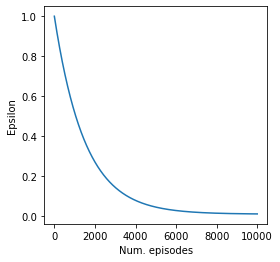

In [8]:
fig, ax = plt.subplots(figsize=(4, 4))

ax.plot([epsilon_by_step(i) for i in range(num_frames)])
ax.set_xlabel("Num. episodes")
ax.set_ylabel("Epsilon")

### Main Loop and Replay Buffer Control

This is the main loop of our DQN implementation. Here we generate the samples added to the replay memory and train the agent using a batch sampled for the replay memory

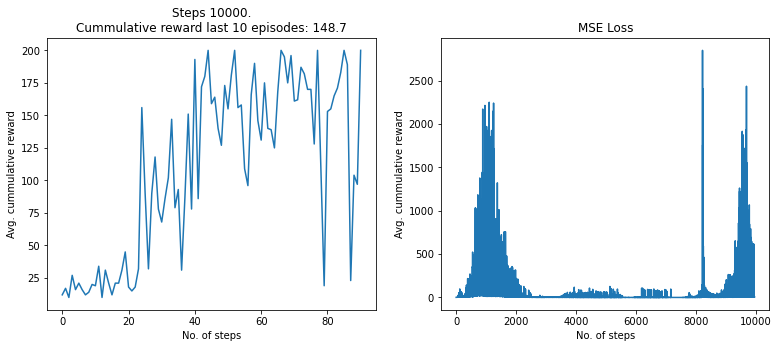

In [9]:
# Define varibles for plotting
losses_list, rewards_list, episode_len_list = [], [], []
list_epsilon = []

# Create instance of reply buffer
replay_buffer = ReplayMemory(memory_capacity)

# Create environment
env = gym.make(env_name)
n_actions = env.action_space.n
dim_state = env.observation_space.shape[0]

# Create agent
agent = DQNAgent(seed=1234, input_dim=dim_state, 
                 output_dim=n_actions, 
                 hidden_dim=hidden_dim, gamma=gamma)

# Reset environment and set all counters and cummulative varibles to zero
state, ep_len, losses, episode_reward = env.reset(), 0, 0, 0

for frame_idx in range(1, num_frames + 1):    
    # Get epsilon
    cur_epsilon = epsilon_by_step(frame_idx)
    
    # Sample action using e-greedy policy
    action = agent.get_action(state, n_actions, cur_epsilon)
    
    # Apply action and observe changes in the environment
    next_state, reward, done, _ = env.step(action.item())
    episode_reward += reward
    
    # Transform observation into Transition tuple
    t_s = torch.tensor(state).float().to(device)
    t_r = torch.tensor([reward]).float().to(device)
    t_ns = torch.tensor(next_state).float().to(device)
    t_a = action.to(device)
    t_done = torch.tensor([done]).bool().to(device)
                
    # Add new sample to replay buffer
    replay_buffer.push(t_s, t_a, t_ns, t_r, t_done)
    state = next_state
    
    ep_len += 1
    
    # If current episode has finished, reset environment and counters for next episode
    if done:
        state = env.reset()
        rewards_list.append(episode_reward)
        episode_len_list.append(ep_len)
        episode_reward, ep_len = 0, 0
    
    # If replay buffer has at least batch_size elements, sample batch and train approximator
    if len(replay_buffer) > batch_size:
        transitions = replay_buffer.sample(batch_size)
        batch = Transition(*zip(*transitions))
        loss = agent.optimize(batch)
        losses_list.append(loss)
    
    # Every 200 steps we plot the approximator's progress and performance
    if frame_idx % 200 == 0:
        plot(frame_idx, rewards_list, losses_list)

### Let's now test our trained model

Can we do better than the random policy?

**Note**: If running in AWS, the visualization will not work. To get the code below running without issue, replace 
```python
env = wrappers.Monitor(env, "./gym-results", force=True)
```
with

```python
env = wrappers.Monitor(env, "./gym-results", force=True, video_callable=False)

```
You can verify the performance of your agent by looking at the cummulative reward 

In [10]:
from gym import wrappers

env = gym.make("CartPole-v0")
env = wrappers.Monitor(env, "./gym-results", force=True)#, video_callable=False)
n_trials = 100
list_rewards = []

for i in range(n_trials):
    observation = env.reset()
    ep_return = 0
    done = False
    while not done:
        action = agent.get_action(observation, n_actions, 0.01)
        observation, reward, done, info = env.step(action.item())
        ep_return += reward
    list_rewards.append(ep_return)
env.close()

fig, ax = plt.subplots(figsize=(4, 4))
ax.plot(list_rewards)
ax.set_xlabel("Num. Trial")
ax.set_ylabel("Return")
ax.set_title('Average return %s +- %s' % (np.round(np.mean(list_rewards),2), np.round(np.std(list_rewards), 2)))

DependencyNotInstalled: Found neither the ffmpeg nor avconv executables. On OS X, you can install ffmpeg via `brew install ffmpeg`. On most Ubuntu variants, `sudo apt-get install ffmpeg` should do it. On Ubuntu 14.04, however, you'll need to install avconv with `sudo apt-get install libav-tools`.

### This is an example of the performance obtained after training the agent with the hyper-parameters listed above

In [11]:
import io
import base64
from IPython.display import HTML

video = io.open('./Support/images/cartPole_learned.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''
    <video width="360" height="auto" alt="test" controls><source src="data:video/mp4;base64,{0}" type="video/mp4" /></video>'''
.format(encoded.decode('ascii')))